# 1. Business understanding

Assessing payment capacity is one of the most important issues when financial institutions need to assign credit limits. Although it might seem trivial, in some cases the information is no available, and due to the informality of some latinamercian economies (Colombia for this study case), it is important to build statistical models that can estimate the income of the customers. 

## What data do we have?

We are going to be using the data from the National Administrative Department of Statistics of Colombia [DANE] (https://www.dane.gov.co). The database is the result of a survey conducted to more than 25k households in three major cities in Colombia for 2018. 

All the data and metadata can be found in [this link] (http://microdatos.dane.gov.co/index.php/catalog/626). The data has 331 variables including spending behaviours and financial burden of the households.

## What question do we want to answer?

1. Can the income be modeled after the spending patterns of the household?
2. Can the income be modeled after the financial burden of the household?
3. Is there a possible way financial institutions can include this informetion in theor models?

# 2. Data Understanding

##  Environment and data

First af all, lets load all needed packages and teh data we will be working with.

In [65]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn import preprocessing
from IPython.display import Image
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [7]:
df = pd.read_csv('./IEFIC_2018.csv', sep=';')
df.head()

C:\Users\Administrador\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (48,50,51,52,53,54,55,56,57,58,59,60,61,62,63,90,108,117,125,134,136,137,138,139,140,141,142,143,144,145,146,147,280) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62838 entries, 0 to 62837
Columns: 331 entries, SECUENCIA_P to P3045
dtypes: int64(29), object(302)
memory usage: 158.7+ MB
None


,SECUENCIA_P,ORDEN,DIRECTORIO,FEX_C,INGRESO_COMPLETO,P6050,P10,INGTOTOB,DEPARTAMENTO,MUNICIPIO,...,P3040,P3040_A,P3040_B,P3040_C,P3040_D,P3040_E,P3040_F,P3043,P3044,P3045
0,1,1,4513825,"100,123276403857",1,1,602,1800000,5,1,...,,0,0,,,,,4,1,1
1,1,2,4513825,"100,123276403857",1,2,407,1500000,5,1,...,,0,,,,,,2,1,3
2,1,3,4513825,"100,123276403857",1,5,305,2000000,5,1,...,,0,,,,0,,1,0,2
3,1,1,4513826,"108,829812109572",1,1,304,2000000,5,1,...,,,,,,,,,2,3
4,1,1,4513827,"110,412858809884",1,1,301,500000,5,1,...,,,,,,0,,,2,2


Reading the database documentation it can be found that there are some household that do not report the total income, and that have one entry for every member of the house (including children). For this reason we are going to keep only the household head and only the households that report total income.

In [8]:
df=df[df['INGRESO_COMPLETO']==1]
df=df[df['P6050']==1]
df=df.replace(r'^\s*$', np.nan, regex=True)
df=df.replace(98, np.nan, regex=True)
df=df.replace('98', np.nan, regex=True)
df=df.replace(99, np.nan, regex=True)
df=df.replace('99', np.nan, regex=True)
df=df[df['INGTOTOB'].notna()]
df=df.reset_index(drop=True)
df.head()

,SECUENCIA_P,ORDEN,DIRECTORIO,FEX_C,INGRESO_COMPLETO,P6050,P10,INGTOTOB,DEPARTAMENTO,MUNICIPIO,...,P3040,P3040_A,P3040_B,P3040_C,P3040_D,P3040_E,P3040_F,P3043,P3044,P3045
0,1,1,4513825,"100,123276403857",1,1,602,1800000,5,1,...,NaN,0,0,NaN,NaN,NaN,NaN,4,1,1
1,1,1,4513826,NaN,1,1,304,2000000,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
2,1,1,4513827,NaN,1,1,301,500000,5,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,2,2
3,1,1,4513829,NaN,1,1,607,3125000,5,1,...,NaN,0,NaN,NaN,NaN,2,NaN,6,0,1
4,1,1,4513831,NaN,1,1,605,6109000,5,1,...,NaN,0,0,NaN,NaN,0,NaN,2,2,6


After reviewing the documentation the following variables were selected. There are basicaly 3 types of variables. Spenditure, debts and investments.

In [9]:
keep=['P10','INGTOTOB','P2439','P2461','P2168','P2471_4','P2477','P2478_1','P2478_2','P2478_3','P2478_4','P2478_5','P2478_6','P2478_7','P2478_8','P2478_9','P2478_10','P2478_11','P2478_12','P2481_1','P2481_2','P2481_3','P2481_4','P2481_5','P2481_6','P2481_7','P2481_8','P2481_9','P2481_10','P2481_11','P2481_12','P2481_13','P2481_14','P2481_15','P2481_16','P2481_17','P2481_18','P2982','P2983','P2985','P2487','P2502','P2503','P2504','P342','P2540','P2542_3','P2542_4','P2545','P2548','P2560_3','P2560_4','P2602','P2623_3','P2623_4','P2633','P2637_3','P2637_4','P2692','P2772_3','P2772_4','P2695','P2736_3','P2736_4','P2734','P2696_3','P2696_4','P2771','P2693_3','P2693_4','P2819','P2869','P622','P1136','P1239','P1421','P2584','P2962']

df=df[keep]

names=['edu_level','income','house_owner','house_value','mortage','mortage_balance','spent_edu','spent_food','spent_clothes','spent_water','spent_energy','spent_gas','spent_cell','spent_housekeep','spent_leisure','spent_health','spent_internet','spent_transport','spent_pension','extra_house','extra_home','extra_jewelry','extra_art','extra_rent','extra_vacations','extra_retirement','extra_emergency','extra_future','extra_edu','extra_debts','extra_health','extra_children','extra_wedding','extra_invest','extra_heritage','extra_remodeling','extra_savings','small_business','small_business_value','real_estate','real_estate_value','vehicles','vehicles_value','machinery','machinery_value','credit_cards','credit_cards_payment','credit_cards_balance','credit_cards_term','pawnshop','pawnshop_payment','pawnshop_balance','loans','loans_payment','loans_balance','shark','shark_payment','shark_balance','shop','shop_payment','shop_balance','union','union_payment','union_balance','edu_loan','edu_loan_payment','edu_loan_balance','friend_loan','friend_loan_payment','friend_loan_balance','stocks','stocks_value','funds','funds_value','tdc','tdc_value','savs_acc','savs_acc_value']

df.columns=names

print(df.shape)
df.head()

(21033, 78)


,edu_level,income,house_owner,house_value,mortage,mortage_balance,spent_edu,spent_food,spent_clothes,spent_water,...,friend_loan_payment,friend_loan_balance,stocks,stocks_value,funds,funds_value,tdc,tdc_value,savs_acc,savs_acc_value
0,602,1800000,1,80000000,NaN,NaN,0,400000,NaN,16000,...,NaN,NaN,2,NaN,2,NaN,2,NaN,2,NaN
1,304,2000000,1,NaN,NaN,NaN,0,700000,NaN,40000,...,NaN,NaN,2,NaN,2,NaN,2,NaN,2,NaN
2,301,500000,2,NaN,NaN,NaN,0,800000,NaN,30000,...,NaN,NaN,2,NaN,2,NaN,2,NaN,2,NaN
3,607,3125000,1,150000000,35000000,NaN,0,600000,50000,17400,...,NaN,NaN,2,NaN,2,NaN,1,NaN,2,NaN
4,605,6109000,1,140000000,22000000,NaN,9000000,1000000,150000,17400,...,NaN,NaN,2,NaN,2,NaN,2,NaN,2,NaN


Now we are going to check for nulls and keep the variables that makes sense.

In [22]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(missing_value_df)

                               column_name  percent_missing
edu_level                        edu_level            0.000
income                              income            0.000
house_owner                    house_owner            0.000
real_estate                    real_estate            0.024
vehicles                          vehicles            0.024
machinery                        machinery            0.024
small_business              small_business            0.024
spent_pension                spent_pension            0.143
credit_cards                  credit_cards            0.238
friend_loan                    friend_loan            0.242
tdc                                    tdc            0.242
funds                                funds            0.242
stocks                              stocks            0.242
pawnshop                          pawnshop            0.242
loans                                loans            0.242
savs_acc                          savs_a

In [43]:
keep_2=['income','spent_edu','spent_food','spent_clothes','spent_water','spent_energy','spent_gas','spent_cell','spent_housekeep','spent_leisure','spent_health','spent_internet','spent_transport','spent_pension','house_value','credit_cards_payment','credit_cards_balance','credit_cards_term','vehicles_value','savs_acc_value']
df=df[keep_2]
df=df.reset_index(drop=True)

print(df.shape)
df.head()

(21033, 20)


,income,spent_edu,spent_food,spent_clothes,spent_water,spent_energy,spent_gas,spent_cell,spent_housekeep,spent_leisure,spent_health,spent_internet,spent_transport,spent_pension,house_value,credit_cards_payment,credit_cards_balance,credit_cards_term,vehicles_value,savs_acc_value
0,1800000,0,400000,NaN,16000,67000,13000,10000,0,200000,0,145000,0,100000,80000000,NaN,NaN,NaN,16000000,NaN
1,2000000,0,700000,NaN,40000,50000,23000,60000,0,100000,0,62000,0,0,NaN,NaN,NaN,NaN,1000000,NaN
2,500000,0,800000,NaN,30000,60000,10000,10000,0,0,0,100000,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3125000,0,600000,50000,17400,30000,9000,50000,0,0,0,0,0,0,150000000,NaN,NaN,NaN,NaN,NaN
4,6109000,9000000,1000000,150000,17400,74000,5000,60000,0,300000,380000,98000,0,0,140000000,NaN,NaN,NaN,7000000,NaN


In [39]:
#sns_plot = sns.heatmap(df.isnull(), cbar=False)
#results_path = 'img/results.png'
#plt.savefig(results_path)

![title](img/nulls.png)

Finally lets check all datatypes are correct

In [44]:
df.dtypes

income                  object
spent_edu               object
spent_food              object
spent_clothes           object
spent_water             object
spent_energy            object
spent_gas               object
spent_cell              object
spent_housekeep         object
spent_leisure           object
spent_health            object
spent_internet          object
spent_transport         object
spent_pension           object
house_value             object
credit_cards_payment    object
credit_cards_balance    object
credit_cards_term       object
vehicles_value          object
savs_acc_value          object
dtype: object

In [46]:
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Now lets check for some correlations

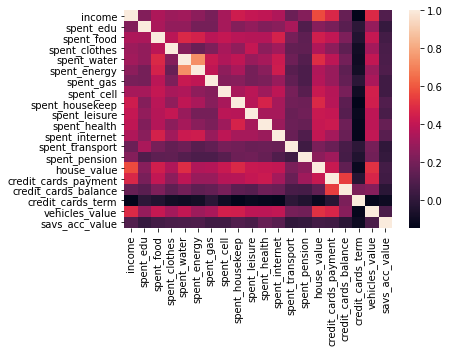

In [48]:
sns.heatmap(df.corr())
plt.show()

There seem to be some obvoius correlations:

1. Income has a big correlation with house value.
2. CRedit card balance and payment.

But there are some that are not that simple:

1. Money spent in utilities is highly correlated
2. Money spent in internet is correlated with money spent in food

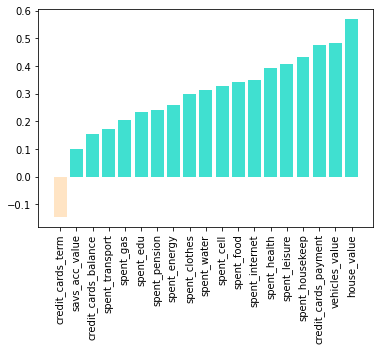

In [49]:
corr_lis=df.corr().stack().reset_index()
corr_lis.columns = ['var_1','var_2','corr']
price_corr=corr_lis[corr_lis['var_1']=='income'].sort_values(by=['corr'])  
price_corr=price_corr[price_corr['var_2']!='income']

x = price_corr['var_2']
y = price_corr['corr']

mask1 = y < 0
mask2 = y >= 0

plt.xticks(rotation = 90)
plt.bar(x[mask1], y[mask1], color = 'bisque')
plt.bar(x[mask2], y[mask2], color = 'turquoise')
plt.show()

 Checking correlations only with 'price' it is clear that the house value is strongly correlated with the price. And the number of payments for the credit card is negatively correlated with the income. Now we are going to impute with the mean.

In [71]:
df=df.fillna(df.mean())

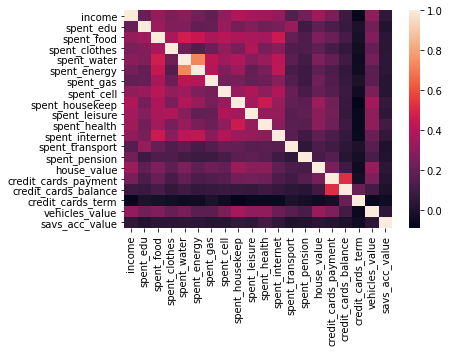

In [72]:
sns.heatmap(df.corr())
plt.show()

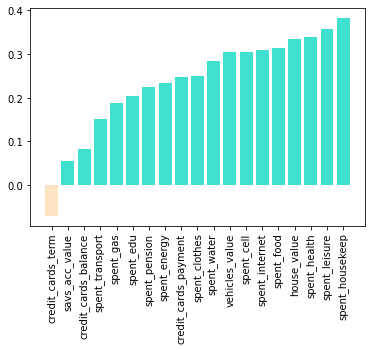

In [73]:
corr_lis=df.corr().stack().reset_index()
corr_lis.columns = ['var_1','var_2','corr']
price_corr=corr_lis[corr_lis['var_1']=='income'].sort_values(by=['corr'])  
price_corr=price_corr[price_corr['var_2']!='income']

x = price_corr['var_2']
y = price_corr['corr']

mask1 = y < 0
mask2 = y >= 0

plt.xticks(rotation = 90)
plt.bar(x[mask1], y[mask1], color = 'bisque')
plt.bar(x[mask2], y[mask2], color = 'turquoise')
plt.show()

There is consistency in the information after impute.

# 4. Modeling

In this section we are going to use a simple random forest to predict the price of the listings. We are going be doing the following steps:

1. Split data
2. Instantiate model and fit
4. Evaluate

## Split data

The data will bi splitted 70/30 for train and test



In [74]:
X = df[['spent_edu','spent_food','spent_clothes','spent_water','spent_energy','spent_gas','spent_cell','spent_housekeep','spent_leisure','spent_health','spent_internet','spent_transport','spent_pension','house_value','credit_cards_payment','credit_cards_balance','credit_cards_term','vehicles_value','savs_acc_value']]

y = df['income']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [76]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (14723, 19)
Training Labels Shape: (14723,)
Testing Features Shape: (6310, 19)
Testing Labels Shape: (6310,)


## Instantiate and fit model

We are going to use a simple Random forest with 1000 estimators.



In [77]:
pipeline = Pipeline(
    [
        ("features", StandardScaler()),
        ("regressor", XGBRegressor()),
    ]
)

In [78]:
names = X.columns

# Cross validation grid definition
hyperparameters = {  "regressor__learning_rate": [0.1, 0.01],
    "regressor__max_depth": [2, 4],
    "regressor__n_estimators": [20, 30, 50],
    "regressor__reg_lambda": [1, 1.5, 2],
    "regressor__gamma": [0, 0.1, 0.3]}

# CV train
Model = GridSearchCV(pipeline, hyperparameters, cv = 10)
 
# Fit and tune model
Model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features', StandardScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                    

## Evaluate Model

Since we did some transformations to the lable (price) for the error meassure to make sense we have to reverse this transormations to our predictions and test labels.



In [79]:
pred = Model.predict(X_test)

In [90]:
MAE= np.mean(abs(pred - y_test))
MSE = np.square(np.subtract(y_test,pred)).mean() 
RMSE = math.sqrt(MSE)

print("Mean Absolute Error:")
print(round(MAE,2))
print("\n")

print("Root Mean Square Error:")
print(round(RMSE,2))

Mean Absolute Error:
781935.57


Root Mean Square Error:
1604596.37


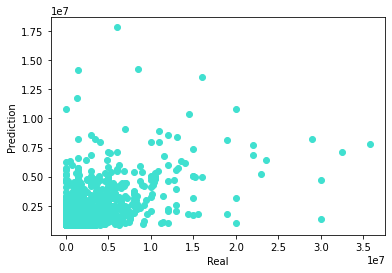

In [92]:
ax = plt.gca()
ax.scatter(y_test, pred, color="turquoise")
plt.xlabel("Real")
plt.ylabel("Prediction");

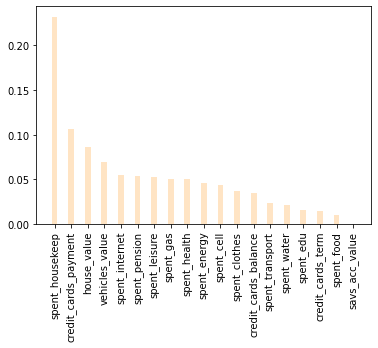

In [107]:
importances = list(Model.best_estimator_._final_estimator.feature_importances_)
labels = X.columns.tolist()
df_imp=pd.DataFrame({'variable': labels,'imp': importances})
df_most=df_imp.sort_values(by=['imp'],ascending=False)

#Plot with importances
fig, ax = plt.subplots()
ax.bar(df_most.variable, df_most.imp, 0.35, color='bisque')
plt.xticks(rotation=90)
plt.show();

# 5. Results, Evaluation and Insights

Regarding our initial questions we have the following


1. Can the income be modeled after the spending patterns of the household?
2. Can the income be modeled after the financial burden of the household?
3. Is there a possible way financial institutions can include this informetion in theor models?

## Conclusion

Wraping up, we found that there is a strong correlation between the location of a listing and its price (kind of obvious), but th real insight here is that the average sentimen of the comments is way more important than the socres given by the guests.